# Optimizing Model - Creating Average Departure and Arrival Delays

In [ ]:
## Model Iteration 2
## Feature Eng: Average departure and arrival delays by flight number (route)  
## Purpose: To measure uplift of adding the average departure and arrival delays by route
## Results : 
##      LightGBM Model RMSE is:  42.00756954088724 (1.14% change)
##      LightGBM Model R2 Score is:  0.06256947947856017 (-5.59% change)
##      LightGBM Model Cross-validation MAE is: 23.33587061291061 (0.38% change)
##      XGBoostModel RMSE is:  42.17275006580812 (-0.99% change)
##      XGBoost Model R2 Score is:  0.055182729642471395 (206.14% change)
##      XGBoost Model Cross-validation MAE is: 22.429796 (-0.78% change)

In [94]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [95]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_03.csv', sep = ',')

In [96]:
df_flight_info = data_flight_info.copy()

In [97]:
df_flight_info.tail()

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,crs_dep_time,dep_time,dep_delay,dest,arr_time,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,month,day,weekday
979643,2018-12-13,AA,YV,5753,DFW,1332,1331.0,-1.0,HSV,1517.0,...,603.0,0.0,0.0,0.0,0.0,0.0,2018,12,13,0.0
979644,2018-01-08,UA,UA,1968,PHL,1451,1447.0,-4.0,DEN,1713.0,...,1558.0,0.0,0.0,0.0,0.0,0.0,2018,1,8,0.0
979645,2018-04-01,UA,UA,1782,BOI,647,644.0,-3.0,DEN,831.0,...,649.0,0.0,0.0,0.0,0.0,0.0,2018,4,1,1.0
979646,2018-10-07,DL,9E,5070,JFK,1655,1700.0,5.0,SYR,1827.0,...,209.0,0.0,0.0,0.0,0.0,0.0,2018,10,7,1.0
979647,2019-03-28,NK,NK,419,CLE,1204,1157.0,-7.0,FLL,1425.0,...,1062.0,0.0,0.0,0.0,0.0,0.0,2019,3,28,0.0


In [98]:
#Only want top 19 busiest airports
airports = ['ORD','ATL','DFW','DEN','LAX','CLT','SEA','SFO','EWR','LGA','PHX','IAH','LAS','BOS','MCO','DTW','PHIL','DCA','MSP']
df_flight_info = df_flight_info[df_flight_info['origin'].isin(airports)]
df_flight_info.origin.value_counts()

ATL    48923
ORD    48428
DFW    35688
DEN    33907
LAX    30969
CLT    30851
SEA    23313
PHX    22252
SFO    22183
IAH    22017
DTW    21795
LAS    20661
LGA    20597
MSP    19965
EWR    19453
BOS    18365
MCO    17474
DCA    17438
Name: origin, dtype: int64

In [99]:
## Grouping Delays

# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [100]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]

In [101]:
# Getting Average NAS Delay - Grouped by Flight Number
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number', 'total_nas_delay']]


# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped[['origin','total_security_delay']]

# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(carrier_grouped, on = 'op_unique_carrier', how = 'outer')

## Model Training

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [103]:
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [104]:
df_flight_info.head(1)

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,crs_dep_time,dep_time,dep_delay,dest,arr_time,...,month,day,weekday,flight_number,total_security_delay,total_nas_delay,average_route_time,total_dep_delay,total_arr_delay,total_carrier_delay
0,2018-07-19,AA,AA,1046,LAX,1120,1129.0,9.0,MSY,1721.0,...,7,19,0.0,1208,0.008073,5.925926,133.925926,11.259259,7.111111,9.526884


In [105]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','average_route_time','crs_arr_time','distance','total_carrier_delay', 'total_security_delay','total_nas_delay','total_dep_delay','total_arr_delay']]
y = df_flight_info['arr_delay']

In [106]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [107]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 331995, number of used features: 11
[LightGBM] [Info] Start training from score 5.729177
Model RMSE is:  41.72262428937797
Model R2 Score is:  0.061861816798388425


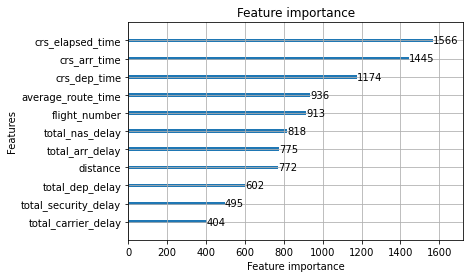

In [108]:
#Examine the importance of each feature column in the original data set with the model
lgb.plot_importance(reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [109]:
# Cross-validate
cv_results = lgb.cv(
        params,
        d_train,
        num_boost_round=100,
        nfold=3,
        metrics='mae',
        early_stopping_rounds=10,

        stratified=False
        )
# Display results
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['l1-mean']))
print('LightGBM Model Cross-validation MAE is:', cv_results['l1-mean'][-1])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 221330, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 221330, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Numbe

##### XGBoost

In [110]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  41.79940941685084
Model R2 Score is:  0.05840559385714117


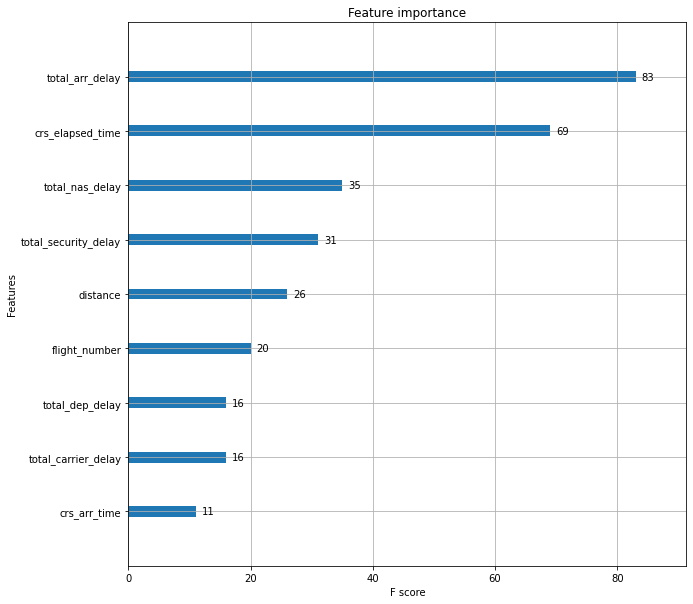

In [111]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [112]:
params = {'objective':'reg:squarederror', 'colsample_bytree' : 0.3, 'learning_rate' : 0.1,
                'max_depth' : 5, 'alpha' : 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="mae", as_pandas=True, seed=123)

print('XGBoost Model Cross-validation MAE is: ',(cv_results["test-mae-mean"]).tail(1))

XGBoost Model Cross-validation MAE is:  0    22.42419
Name: test-mae-mean, dtype: float64


##### Linear Regression

In [113]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  41.62813323606388
Model R2 Score is:  0.08468982851882045


In [114]:
from numpy import mean
from numpy import absolute

#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = lr

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Linear Model Cross-validation MAE is: ',mean(absolute(scores)))

Linear Model Cross-validation MAE is:  23.437121834172626


##### Ridge/Lasso Regression

In [115]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Ridge Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Ridge Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Lasso Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Lasso Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Ridge Model RMSE is:  41.628295038277436
Ridge Model R2 Score is:  0.08468271316253895
Lasso Model RMSE is:  41.64445806517105
Lasso Model R2 Score is:  0.08397179430303114


In [116]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple ridge regression model
model = ridgereg

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Ridge Model Cross-validation MAE is: ',mean(absolute(scores)))

#build multiple lassp regression model
model = lassoreg

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Lasso Model Cross-validation MAE is: ',mean(absolute(scores)))

Ridge Model Cross-validation MAE is:  23.43659919818885
Lasso Model Cross-validation MAE is:  23.41344664661803
